In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.style.use('seaborn-white')

combined_edge = pd.read_csv('~/nas2/integrate_net/rf_greater_than_06.csv', index_col = 0)

combined = nx.from_pandas_edgelist(combined_edge, target = 'target', source = 'source',  edge_attr = ['eskape', 'string', 'gosim', 'domain', 'refseq', 'total_score'])

In [2]:
import os
base_path = '/home/hermuba/nas2/resist_subnet/'
annotation_df = os.path.join(base_path, 'gold_anno.csv')
gold_anno = pd.read_csv(annotation_df)
gold_anno.set_index('gene_id', inplace = True)

In [3]:
from glob import glob
scoary_result = '/nas2/users/hermuba/scoary'
# list of antibiotics
abx_list = [x.split('/')[-1].split('_')[0] for x in glob(scoary_result+'/*.results.csv')]

def read_scoary(abx):
    fname = os.path.join(scoary_result,'{}_08_02_2021_1335.results.csv').format(abx)
    df = pd.read_csv(fname, header = 0, index_col = 0)
    return df
def filter_scoary(df):
    
    return df.loc[(df['Benjamini_H_p']<0.05)& (df['Odds_ratio']>8)]


In [13]:
# join_abx_list
all_resistant_genes = set()
for abx in abx_list:
    resist_genes = filter_scoary(read_scoary(abx)).index.tolist()
    gene_ids = gold_anno.loc[gold_anno['cluster'].isin(resist_genes)].index
    all_resistant_genes.update(gene_ids)
    

In [15]:
# binary df
resist_df = pd.DataFrame(columns = abx_list, index = list(all_resistant_genes))

for abx in abx_list:
    resist_genes = filter_scoary(read_scoary(abx)).index.tolist()
    gene_ids = gold_anno.loc[gold_anno['cluster'].isin(resist_genes)].index
    resist_df.loc[gene_ids, abx] = 1
resist_df.fillna(0, inplace = True)

In [36]:
resist_df = resist_df.loc[:, resist_df.sum(axis = 0)>0]

In [17]:
# assign gene cluster

In [52]:
resist_df.columns

Index(['piperacillin-tazobactam', 'chloramphenicol', 'tobramycin',
       'tetracycline', 'ceftazidime', 'amoxicillin-clavunate', 'ciprofloxacin',
       'trimethoprim', 'ampicillin', 'ceftriaxone', 'gentamicin', 'cefotaxime',
       'streptomycin', 'meropenem', 'imipenem', 'amoxicillin',
       'trimethoprim-sulfamethoxazole', 'amoxicillin-clavulanate',
       'azithromycin', 'cefuroxime'],
      dtype='object')

In [18]:
drug_subnet = combined.subgraph(all_resistant_genes)

In [19]:
drug_subnet

In [21]:
from networkx.algorithms.community import greedy_modularity_communities
def is_community_small(c, n = 20):
    
    violate = len([i for i in c if len(i)>n])
    return violate == 0

c = list(greedy_modularity_communities(drug_subnet))

while not is_community_small(c):
    for community in c:
        if len(community) > 20:
            c.remove(community)
            smaller_net = drug_subnet.subgraph(community)
            new_comm = greedy_modularity_communities(smaller_net)
            c.append(new_comm)
        #print([len(i)<20 for i in c])
    


In [28]:
gene_sets = [c for c in nx.connected_components(drug_subnet) if len(c)>1]

In [39]:
gene_cluster = pd.DataFrame(index = resist_df.index)
for i, gset in enumerate(gene_sets):
    gene_cluster.loc[gset, 'group'] = i

In [41]:
# color coding 
import numpy as np
import matplotlib.cm as cm

def make_lut(series, start = 2, rot = 0):
    '''
    input data series, return color mapping dictionary
    '''
    labels = series.dropna().unique()
    lut = dict(zip(set(labels), sns.cubehelix_palette(len(set(labels)), start = start, rot = rot))) # change l,s
    
    
    return(lut, series.map(lut))

def map_color_for_dataframe(df):
    
    no_cols = df.shape[1]
    
    # evenly distribute color around
    rots = [-1 + i* 3/no_cols for i in range(no_cols)]
    starts = [-1 + i* 3/no_cols for i in range(no_cols)]
    
    color_df = pd.DataFrame(columns = df.columns, index = df.index)
    luts = {}
    r = 0
    for col in df.columns:
        lut, color = make_lut(df[col], rot = rots[r], start = starts[r])
        color_df[col] = color
        luts[col] = lut
        r+=1
    return color_df, lut 

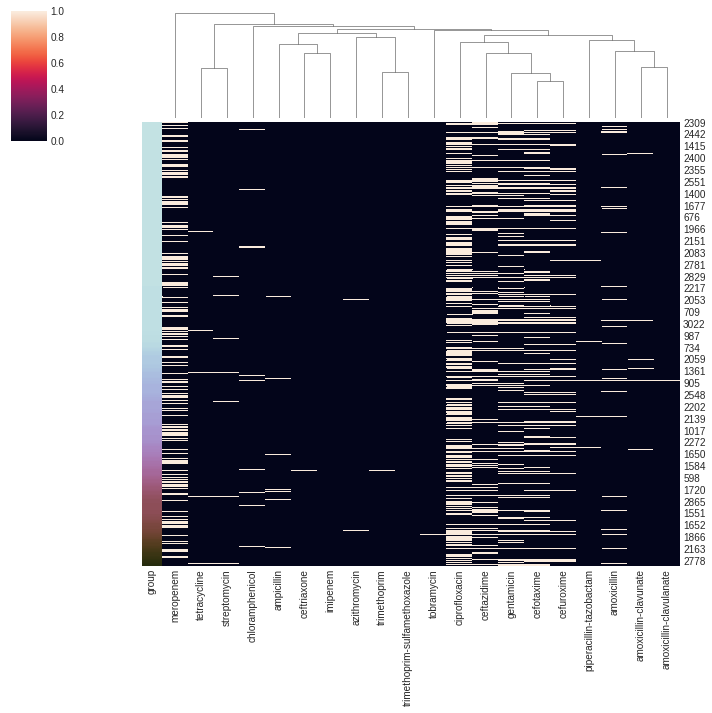

In [50]:
import seaborn as sns
col, lut = map_color_for_dataframe(gene_cluster)
sns.clustermap(resist_df.loc[gene_cluster.dropna().sort_values(by = 'group').index], metric = 'correlation', row_colors = col, row_cluster = False)